# ARIMA Interrupted Analysis of Tilapia Prices 

January 24, 2020

This IPython notebook details the step-by-step process of creating an ARIMA model for interrupted time-series analysis of tilapia prices. <br><br>


Abstract: Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut scelerisque pretium consequat. Proin porttitor, odio id congue iaculis, nibh tortor sodales massa, at porttitor leo velit a turpis. Etiam ultrices lacus ac sem egestas facilisis. Vivamus ac luctus sapien. Sed sagittis ut lorem sit amet semper. Proin nec quam nec odio finibus placerat. Nam ultricies, diam eget consequat pulvinar, tellus nisi pharetra leo, id imperdiet nibh dui et neque. Ut sed enim at massa eleifend pretium. Praesent finibus hendrerit nulla nec scelerisque. Sed ut malesuada enim. <br><br>



Datasets from: https://www.da.gov.ph/price-monitoring/ <br>
Range of dataset used (before lockdowns): **October 01, 2019 - March 14, 2020** <br>
Range of dataset used (after first lockdown): **March 16, 2020 - August 29, 2020**

## Table of Contents
* <a href = '#Python-Modules'>Python Modules </a>
* <a href = '#Reading-the-parsed-data'>Reading the parsed data</a>
* <a href = '#Visualizing-the-data'>Visualizing the data</a>
* <a href = '#Developing-the-ARIMA-Model'>Developing the ARIMA Model</a>
* <a href = '#Testing-for-stationarity'>Testing for stationarity</a>
* <a href = '#Differencing-observations-by-an-order-of-one'>Differencing observations by an order of one</a>
* <a href = '#Retesting-differenced-observations'>Retesting differenced observations </a>
* <a href = '#Determining-autoregression-and-moving-average-terms'>Determining autoregression and moving average terms</a>
* <a href = '#ARIMA(0,1,2)-fitting-and-summary'>ARIMA(0,1,2) fitting and summary</a>
* <a href = '#Counterfactual-model-fitting-and-visualization'>Counterfactual model fitting and visualization</a>
* <a href = '#Diagnosing-ARIMA-model-residuals'>Diagnosing ARIMA model residuals</a>
* <a href = '#Evaluating-the-ARIMA-Model-with-RMSE'>Evaluating the ARIMA Model with RMSE</a>
* <a href = '#Evaluating-level-of-differences-between-treated-and-counterfactual'>Evaluating level of differences between treated and counterfactual</a>
* <a href = '#Discussion-of-the-results'>Discussion of the results</a>

### Python Modules

In [1]:
# Standard data processing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as sp

# Statistical testing modules
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

# Additional math modules
from sklearn.metrics import mean_squared_error
from math import sqrt

# Remove unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Reading the parsed data

In [2]:
tilapia_df = pd.read_csv('C:\\Users\\infot\\Desktop\\data analytics\\data analytics scripts\\interrupted csv\\tilapia.csv', parse_dates=[0], index_col=0)

# Pandas and Matplotlib plotting fix
pd.plotting.register_matplotlib_converters()

### Visualizing the data

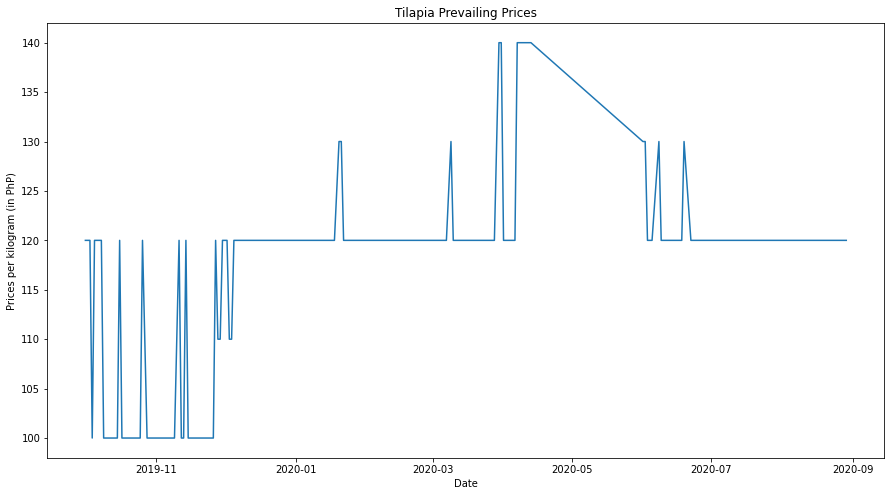

In [3]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Tilapia Prevailing Prices", xlabel = "Date", ylabel = "Prices per kilogram (in PhP)")
ax.plot(tilapia_df)
plt.show()

In [4]:
tilapia_df.head()

,prevailing
2019-10-01,120.0
2019-10-02,120.0
2019-10-03,120.0
2019-10-04,100.0
2019-10-05,120.0


In [5]:
tilapia_df.describe()

,prevailing
count,287.000000
mean,120.134395
std,10.174564
min,100.000000
25%,120.000000
50%,120.000000
75%,120.000000
max,140.000000


## Developing the ARIMA Model
The ARIMA model is a generalized autoregression and moving average model used in time-series analysis. The model requires the necessity the analyze for the number of autoregression terms, nonseasonal differences for stationarity, and moving average terms making it **ARIMA(p,d,q)**. 

#### Construction of an ARIMA Model
1. Stationarizing the series by differencing
2. Analyzing the autocorrelations and partial autocorrelations to determine the number of autoregression and moving average terms 
3.  Fitting the model and diagnosing residuals 
4.  Adjusting the number of autogression and moving average terms if necessary
<br>


For this model, it is necessary to determine if the time-series inputs are stationary. A stationary time-series is one whose process does not depend on time. Specifically, having the properties of constant mean and constant variance as the time-series goes on.

### Testing for stationarity
For this time-series, the researcher will use the Augmented Dicky-Fuller test for stationarity. The Augmented Dicky-Fuller test is a common unit root test for determining stationarity that includes a high order autoregressive process compared to its counterpart, the Dicky-Fuller test. Both these tests assume are used to determine if a time-series has a unit root, a characteristic of time-series to be non-stationary <br>

#### The usual hypotheses for this test are:
Ho: The time-series has a unit root. It is non-stationary <br>
H1: The time-series is stationary <br>

The result of this test reveals that time-series is non-stationary. Therefore, it is necessary to difference the series.

In [6]:
# Defining ADF function
def adfuller_test(dataframe):
    result=adfuller(dataframe)
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho). Therefore, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis. The time series has a unit root, indicating it is non-stationary")

In [7]:
# Calling the ADF function
adfuller_test(tilapia_df['prevailing'])

ADF Test Statistic : -1.9972133536709344
p-value : 0.2877962815967986
Number of Lags Used : 13
Number of Observations Used : 273
Weak evidence against null hypothesis. The time series has a unit root, indicating it is non-stationary


### Differencing observations by an order of one

In [8]:
tilapia_stationary = tilapia_df.diff().dropna()

<AxesSubplot:>

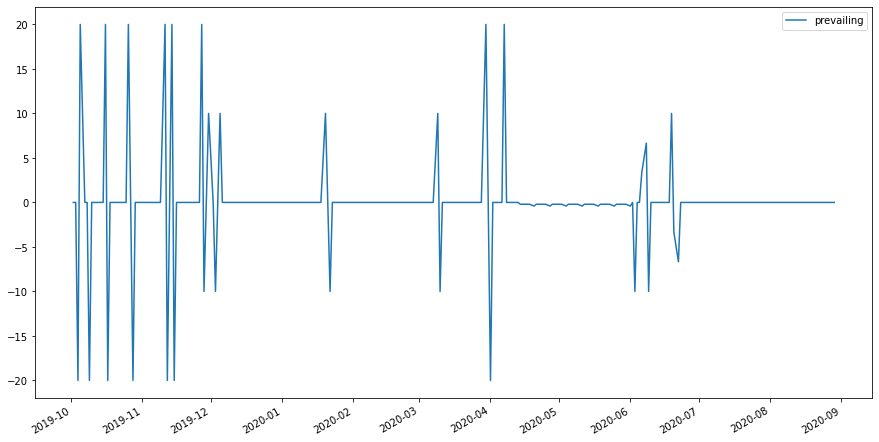

In [9]:
tilapia_stationary.plot(figsize=(15, 8))

In [10]:
tilapia_stationary.head()

,prevailing
2019-10-02,0.0
2019-10-03,0.0
2019-10-04,-20.0
2019-10-05,20.0
2019-10-07,0.0


### Retesting differenced observations
The result of the test reveals that time-series is stationary after differencing once. The time-series needs differencing to be considered stationary. Further testing higher orders of differencing reveals higher standard deviations. Since the ACF and PACF of the differenced observations are small and patternless, the time-series does not need to be differenced any further. Thus, the order of differencing for this model is one.

In [11]:
adfuller_test(tilapia_stationary['prevailing'])

ADF Test Statistic : -4.594738750746413
p-value : 0.0001320848029800295
Number of Lags Used : 12
Number of Observations Used : 273
Strong evidence against the null hypothesis(Ho). Therefore, reject the null hypothesis. Data has no unit root and is stationary


### Determining autoregression and moving average terms
A systematic way of determining the AR and MA terms of an ARIMA model is by looking at the autocorrelation and partial autocorrelation plots of the time-series. In general, there are a few rules that can be used for identifying the proper ARIMA model using the ACF and PACF plots:
* If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.
* If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.
* It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.
* If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.
* If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.
* If the long-term forecasts appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

For this time-series, the lag-1 correlation is negative and the ACF displays a sharper cutoff. The ARIMA model can include MA(2) terms as it cuts off at lag-2.

#### Plotting autocorrelation function of differenced observations

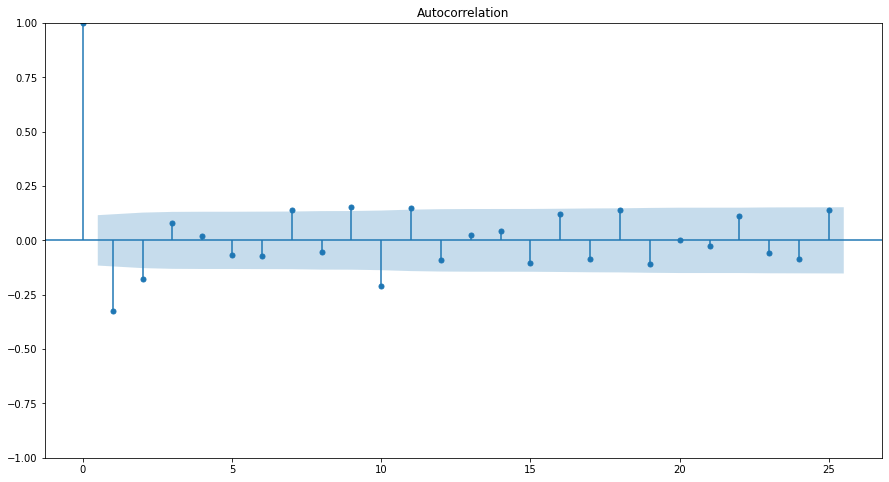

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Autocorrelation")
plot_acf(tilapia_stationary, ax=ax)
plt.show()

#### Plotting partial autocorrelation function of differenced observations

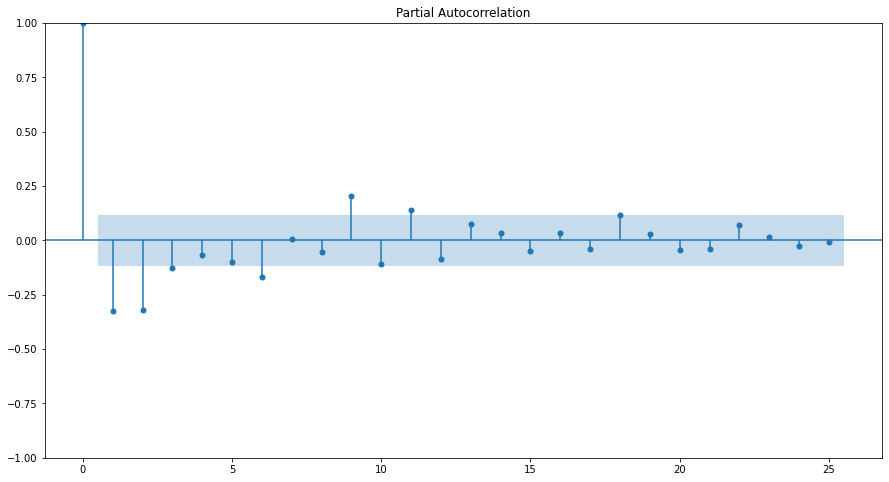

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Partial Autocorrelation")
plot_pacf(tilapia_stationary, method='ywm', ax=ax)
plt.show()

### ARIMA(0,1,2) fitting and summary
Here is a model fitting of the entire dataset before and after the initial lockdown. The model is determined to have no order of differencing and one auto-regressive terms. The result summary shows that the auto-regressive terms are significant and the model does not show a lack of good fit--in other words, the model is fine.

In [14]:
model = ARIMA(tilapia_df, order=(0,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             prevailing   No. Observations:                  287
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -831.322
Date:                Thu, 10 Feb 2022   AIC                           1668.644
Time:                        20:39:29   BIC                           1679.612
Sample:                             0   HQIC                          1673.041
                                - 287                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4915      0.034    -14.480      0.000      -0.558      -0.425
ma.L2         -0.1567      0.044     -3.594      0.000      -0.242      -0.071
sigma2        19.5688      0.730     26.796      0.000      18.137      21.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1215.76
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Visualization of the predicted model

In [15]:
# Training data fit
tilapia_df['training'] = model_fit.predict(start=datetime(2019,10,1), end=datetime(2020,8,29))
tilapia_df.at['2019-10-01', 'training'] = tilapia_df['prevailing'].mean()

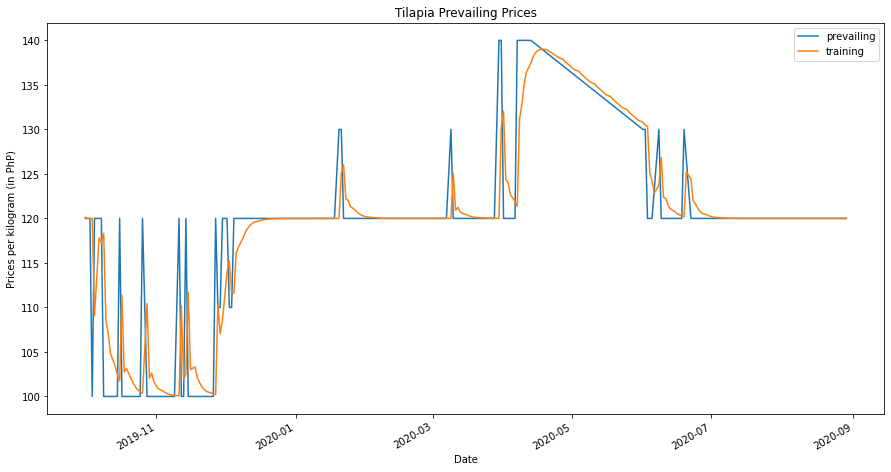

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "Tilapia Prevailing Prices", xlabel = "Date", ylabel = "Prices per kilogram (in PhP)")
tilapia_df.plot(ax=ax)
plt.show()

In [17]:
tilapia_df.head()

,prevailing,training
2019-10-01,120.0,120.134395
2019-10-02,120.0,119.999027
2019-10-03,120.0,119.999313
2019-10-04,100.0,119.999597
2019-10-05,120.0,109.082917


In [18]:
tilapia_df.tail()

,prevailing,training
2020-08-25,120.0,120.0
2020-08-26,120.0,120.0
2020-08-27,120.0,120.0
2020-08-28,120.0,120.0
2020-08-29,120.0,120.0


### Counterfactual model fitting and visualization
In an interrupted time-series analysis, the counterfactual is the supposed prediction of the time-series if the intervention did not happen. For this study, the covid lockdowns are treated as the intervention.  

In [19]:
# Indexes for counterfactual fitting
boundary = 143
#end = 286

# Fitting the counterfactual model
model2 = ARIMA(tilapia_df["prevailing"][:boundary], order=(0,1,2))
model_cf = model2.fit()
model_cf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             prevailing   No. Observations:                  143
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -437.032
Date:                Thu, 10 Feb 2022   AIC                            880.065
Time:                        20:39:29   BIC                            888.932
Sample:                             0   HQIC                           883.668
                                - 143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6491      0.062    -10.455      0.000      -0.771      -0.527
ma.L2         -0.0311      0.066     -0.469      0.639      -0.161       0.099
sigma2        27.4758      1.696     16.198      0.000      24.151      30.800
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               258.70
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Dataframe for intervention period
interrupted = model_fit.predict(start=datetime(2020,3,16), end=datetime(2020,8,29))
interrupted_df = pd.DataFrame(interrupted)
interrupted_df.columns = ['treated']

In [21]:
# Setting frequency offset
week = "Mon Tue Wed Thu Fri Sat"
nosun = pd.offsets.CustomBusinessDay(weekmask=week)

# Make daterange of counterfactual dates
idx_cf = pd.date_range(start = '2020-03-16', end = '2020-08-29', freq = nosun)

# Fit counterfactual predictions
future = model_cf.get_forecast(144).summary_frame(alpha=0.05)

# Format as dataframe
future_df = pd.DataFrame(future)
future_df['date'] = idx_cf
future_df = future_df.set_index('date')
future_df.columns = ['counterfactual','mean_se','mean_ci_lower','mean_ci_upper']

In [22]:
# Additional dataframe for confidence interval 
conf_df = future_df[['mean_ci_lower', 'mean_ci_upper']]
conf_df['date'] = idx_cf
conf_df = conf_df.set_index('date')
conf_df.columns = ['lower bound', 'upper bound']
future_df = future_df.drop(columns =['mean_ci_lower','mean_ci_upper'])

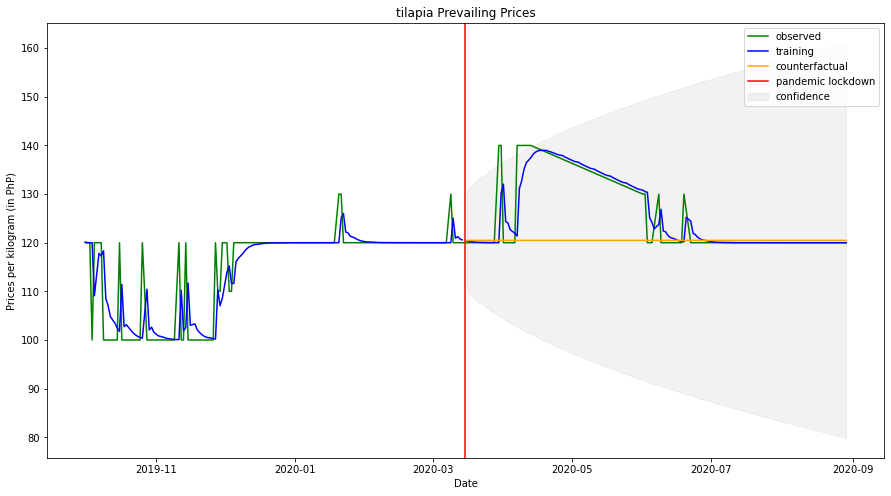

In [23]:
# Plotting the time series
fig, ax = plt.subplots(figsize=(15, 8))
ax.set(title = "tilapia Prevailing Prices", xlabel = "Date", ylabel = "Prices per kilogram (in PhP)")
ax.plot(tilapia_df['prevailing'], color='green',label="observed")
ax.plot(tilapia_df['training'][:boundary], color='blue',label="training")
ax.plot(tilapia_df['training'][boundary:], color='blue')
ax.plot(future_df['counterfactual'], color='orange',label="counterfactual")
ax.axvline(x=datetime(2020,3,15), color = 'r', label = 'pandemic lockdown')
ax.fill_between(idx_cf, conf_df['lower bound'], conf_df['upper bound'], color="black", alpha=0.05, label="confidence")
ax.legend(loc='best')
#plt.show()

In [24]:
future_df.head()

,counterfactual,mean_se
date,,
2020-03-16,120.462515,5.241736
2020-03-17,120.483227,5.555110
2020-03-18,120.483227,5.802589
2020-03-19,120.483227,6.039937
2020-03-20,120.483227,6.268303


In [25]:
future_df.tail()

,counterfactual,mean_se
date,,
2020-08-25,120.483227,20.463342
2020-08-26,120.483227,20.531906
2020-08-27,120.483227,20.600241
2020-08-28,120.483227,20.668351
2020-08-29,120.483227,20.736237


### Diagnosing ARIMA model residuals
The residuals show non-significant autocorrelations, normal distributions, and a mean closer to zero indicating good fit

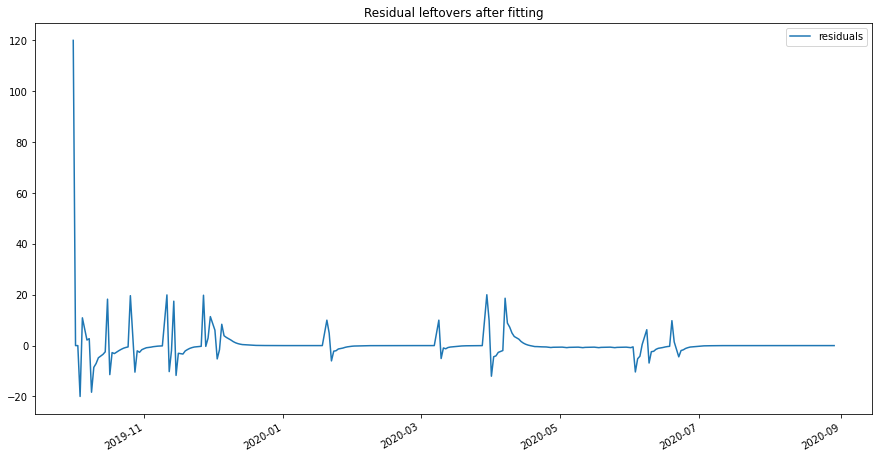

In [26]:
residuals = pd.DataFrame(model_fit.resid)
residuals.columns = ['residuals']
residuals.plot(figsize=(15, 8), title="Residual leftovers after fitting")
plt.show()

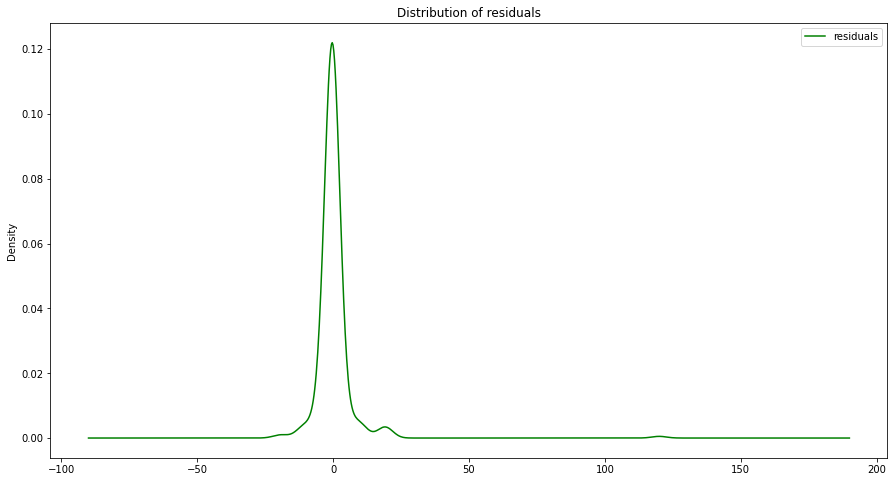

In [27]:
residuals.plot.kde(figsize=(15, 8), color="green", title="Distribution of residuals")
plt.show()

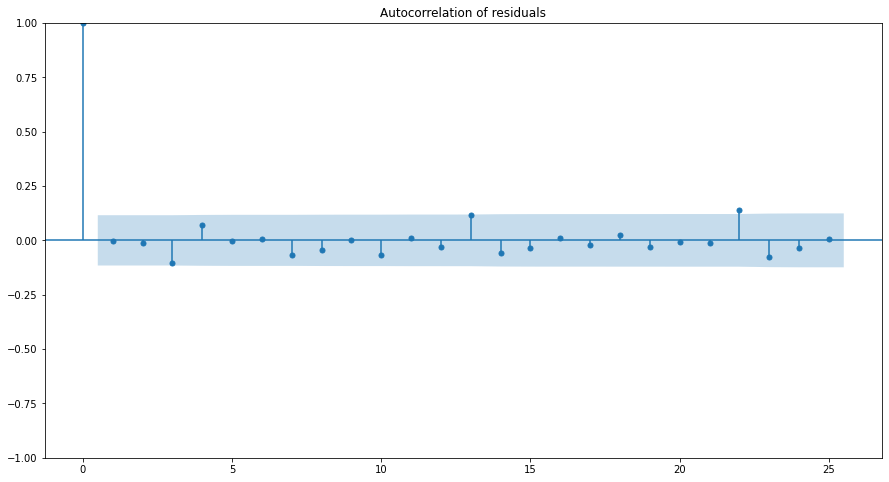

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(residuals, title = "Autocorrelation of residuals", ax=ax)
plt.show()

### Evaluating the ARIMA Model with RMSE
The root mean squared error shows 10.94 which is minimal enough to prove for accuracy

In [29]:
mse = mean_squared_error(tilapia_df['prevailing'], tilapia_df['training'])
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 4.425940


### Evaluating level of differences between treated and counterfactual
In this study, the treated are the prices after the pandemic lockdown and the counterfactual are the prices without the lockdown. For this study, the difference between the two during March, July, and August of 2020 demonstrate the impact of the intervention.

In [30]:
interrupted_df['delta'] = interrupted_df['treated'] - future_df['counterfactual']
results = interrupted_df['delta'].describe()
print("Mean difference: %f" % results[1])
print("Minimum difference: %f" % results[3])
print("Max difference: %f" % results[7])

Mean difference: 5.280556
Minimum difference: -0.483227
Max difference: 18.514865


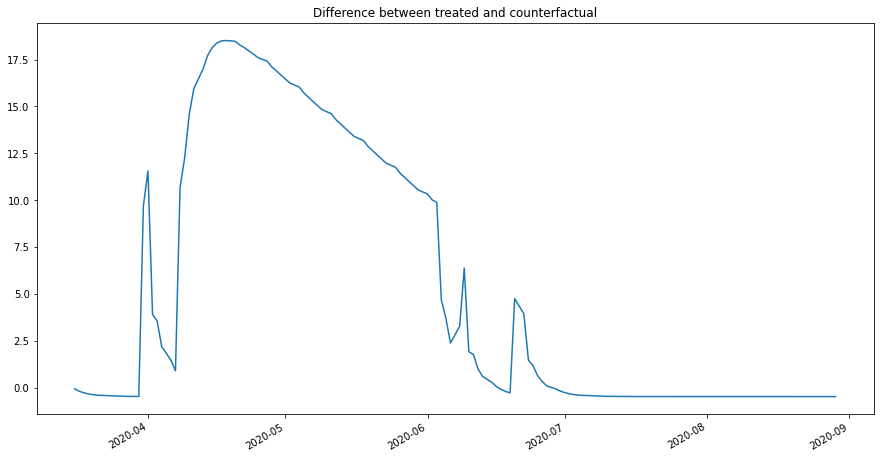

In [31]:
interrupted_df['delta'].plot(figsize=(15, 8), title="Difference between treated and counterfactual")
plt.show()

### Discussion of the results
* The autocorrelation of the residuals show almost no significant values. 
* The RMSE shows minimal error
* The Ljung-Box test accepts the null hypothesis indiciating good fit
* The other parts of the summary indicates that the moving average term is significant 

This result implies that ARIMA(0,1,2) is a good fit for forecasting fish prices during the even accounting for the pandemic lockdowns and for analyzing interventions. The presence of observed prices outside of the counterfactual's confidence interval are indicative of an impact from the intervention itself. There is an observed difference during the months of April through June of 2020.